In [2]:
#Import relevant libraries and define settings for plotting.
%matplotlib inline
import sys
print(sys.version)

import numpy as np
print( 'Numpy version:', np.__version__)

import pandas as pd
print ('Pandas version:', pd.__version__)

import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version:', mpl.__version__)

import seaborn as sns
print ('Seaborn version:', sns.__version__)

import datetime
import time

sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

#Avoid display of scientific notation and show precision of 4 decimals:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.18.1
Pandas version: 1.0.1
Matplotlib version: 3.1.3
Seaborn version: 0.10.0


In [4]:
df_uber = pd.read_csv('uber-raw-data-janjune-15.csv')

In [5]:

df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14270479 entries, 0 to 14270478
Data columns (total 4 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Dispatching_base_num  object
 1   Pickup_date           object
 2   Affiliated_base_num   object
 3   locationID            int64 
dtypes: int64(1), object(3)
memory usage: 435.5+ MB


In [6]:
df_uber.head()


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [7]:
len(df_uber.locationID.unique())

262

In [8]:
len(df_uber[df_uber.duplicated() == True])

898225

In [9]:
df_uber.isnull().sum()

Dispatching_base_num         0
Pickup_date                  0
Affiliated_base_num     162195
locationID                   0
dtype: int64

In [10]:
df_uber.isnull().any()

Dispatching_base_num    False
Pickup_date             False
Affiliated_base_num      True
locationID              False
dtype: bool

In [11]:
len(df_uber[df_uber.Pickup_date.apply(lambda x: x[-5:] == '00:00') == False])

14104988

In [12]:
def dateParser(s):
    """
    Function that takes a string in the format yyyy-mm-dd hh:mm:ss, and
    returns the same as a datetime object.
    """
    return datetime.datetime(int(s[0:4]), int(s[5:7]), int(s[8:10]), int(s[11:13]))

In [13]:
t0 = time.time()
df_uber['pu_date_hour'] = df_uber.Pickup_date.apply(dateParser)
time.time() - t0

28.91856575012207

In [14]:
beginning = df_uber.pu_date_hour.min()
end = df_uber.pu_date_hour.max()
print (beginning, end, end - beginning)
##Data encompasses exactly 180 days from JAN 1st, 2015 to JUNE 30th, 2015.

2015-01-01 00:00:00 2015-06-30 23:00:00 180 days 23:00:00


In [15]:
#Get all federal holidays in the period
from pandas.tseries.holiday import USFederalHolidayCalendar

#if return_name is True, then name is series value and date is the series index, otherwise date is series value.
holidays = USFederalHolidayCalendar().holidays(beginning, end, return_name = True) 
holidays

2015-01-01                 New Years Day
2015-01-19    Martin Luther King Jr. Day
2015-02-16                Presidents Day
2015-05-25                  Memorial Day
dtype: object

In [16]:
holidays.index.map(lambda x: x.strftime('%a'))
#these are just federal holidays but we also have non federal holidays (valentine' day ,10th may-sunday-mothers day, 1st Feb Super Bowl Sporting event	)
# 3rd april friday-(good friday),5th april(easter sunday),6th april(easter monday),21 june fathers day sunday.

Index(['Thu', 'Mon', 'Mon', 'Mon'], dtype='object')

In [17]:
#For completeness, let's add the day before and after the holidays (better: add day after if Thursday)
holidays_all = pd.concat([holidays, "Day After " + holidays.shift(1, 'D'), "Day Before " + holidays.shift(-1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head(10)

2014-12-31                 Day Before New Years Day
2015-01-01                            New Years Day
2015-01-02                  Day After New Years Day
2015-01-18    Day Before Martin Luther King Jr. Day
2015-01-19               Martin Luther King Jr. Day
2015-01-20     Day After Martin Luther King Jr. Day
2015-02-15                Day Before Presidents Day
2015-02-16                           Presidents Day
2015-02-17                 Day After Presidents Day
2015-05-24                  Day Before Memorial Day
dtype: object

In [18]:

#Create a column with the date, without the time. This will be useful later.
t0 = time.time()
df_uber['pu_date'] = pd.Series(map(lambda x: x.astype('datetime64[D]'), df_uber['pu_date_hour'].values))
#df_uber['pu_date'] = df_uber['pu_date_hour'].dt.date #this is way less memory effective and 11 sec slower to execute
time.time() - t0

29.878592252731323

In [19]:
#Get month and year from pick up timestamp
df_uber['year'] = df_uber['pu_date_hour'].dt.year
df_uber['month'] = df_uber['pu_date_hour'].dt.month

In [20]:
#Get trip pick up day of the month
t0 = time.time()
df_uber['day'] = df_uber['pu_date_hour'].dt.day
time.time() - t0

1.0745506286621094

In [21]:
#Get trip pick up day of the month
t0 = time.time()
df_uber['day'] = df_uber['pu_date_hour'].dt.day 
time.time() - t0

1.1304047107696533

In [22]:
#Get trip pick up hour from timestamp
t0 = time.time()
df_uber['hour'] = df_uber['pu_date_hour'].dt.hour #< 2 seconds vs 101 seconds using apply lambda
time.time() - t0

1.079077959060669

In [23]:

#Get trip pick up weekday from timestamp
t0 = time.time()
df_uber['weekday'] = df_uber['pu_date_hour'].dt.dayofweek
time.time() - t0

1.175842046737671

In [24]:

df_uber.weekday.value_counts() #Monday = 0, Sunday = 6

5    2414563
4    2282571
3    2159598
6    1952782
2    1893811
1    1872902
0    1694252
Name: weekday, dtype: int64

In [25]:

df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,pu_date_hour,pu_date,year,month,day,hour,weekday
0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6


In [26]:
df_uber = df_uber.drop('Pickup_date', axis=1)

In [27]:
df_uber.head()

,Dispatching_base_num,Affiliated_base_num,locationID,pu_date_hour,pu_date,year,month,day,hour,weekday
0,B02617,B02617,141,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
1,B02617,B02617,65,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
2,B02617,B02617,100,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
3,B02617,B02774,80,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6
4,B02617,B02617,90,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6


In [28]:
pip install calmap

Note: you may need to restart the kernel to use updated packages.


In [30]:
import matplotlib.mlab as mlab

In [31]:
from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox) #Create image box
from matplotlib._png import read_png #Load png file
from matplotlib.patches import Ellipse #Draw ellipse

In [32]:
#Create functions to format tick numbers
def thousands_comma(x, pos):
    """
    Args are the value and tick position. 
    Returns number with thousands comma and no decimals.
    """
    return '{:,.0f}'.format(x) #this is the new syntax for formatting

In [33]:
def thousands_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with one decimal, and K in lieu of 3 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-3, 'K') #old syntax: '%1.0fK' % (x * 1e-3)


In [34]:
def millions_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with one decimal, and M in lieu of 6 zeros.
    """
    return '{:.1f}{}'.format(x * 1e-6, 'M')

In [35]:
def millions_currency(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with a $ sign, M in lieu of 6 zeros, and no decimals.
    """
    return '{}{:.0f}{}'.format('$', x * 1e-6, 'M')

In [36]:
#Define robust function to automatically add annotated labels on bar plots.
#Inspiration from http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
    return None

In [37]:
byDate = df_uber.groupby('pu_date')['locationID'].count() #365 complete entries
byDate.head()

pu_date
2015-01-01    58045
2015-01-02    40287
2015-01-03    59844
2015-01-04    41943
2015-01-05    43678
Name: locationID, dtype: int64

In [38]:
byDate['2015-01-01': '2015-06-30']

pu_date
2015-01-01     58045
2015-01-02     40287
2015-01-03     59844
2015-01-04     41943
2015-01-05     43678
               ...  
2015-06-26     99508
2015-06-27    136193
2015-06-28     93108
2015-06-29     74430
2015-06-30     82627
Name: locationID, Length: 181, dtype: int64

In [39]:

# Python program to read 
# image using PIL module 
  
# importing PIL 
from PIL import Image 
  
# Read image 
img = Image.open('valentinesday.png') 
  
# Output Images 
img.show() 
  
# prints format of image 
print(img.format) 
  
# prints mode of image 
print(img.mode) 

PNG
P


In [40]:
from PIL import Image

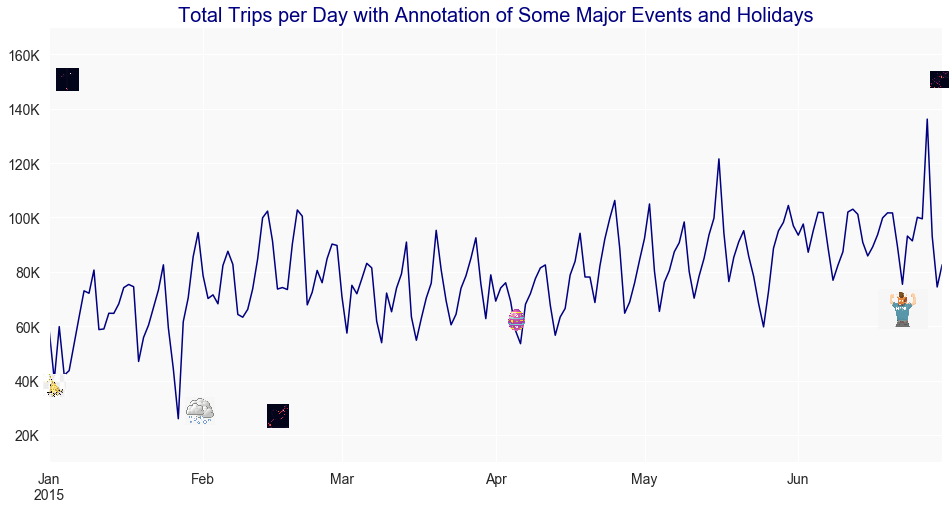

In [41]:
#Create a plot with the total number of trips per day, highlighting some changepoints associated with major holidays 
#and other weather and touristic/cultural events.

fig = plt.figure()

ax = byDate.plot(figsize = (16, 8), fontsize = 12, ylim = (10000, 170000), color = 'navy')

formatter = FuncFormatter(thousands_format)
ax.yaxis.set_major_formatter(formatter)
ax.set_facecolor('#F9F9F9') #make background color a lighter gray to better contrast with the icon's images.

plt.title('Total Trips per Day with Annotation of Some Major Events and Holidays', fontsize= 20, color='navy')
plt.tick_params(labelsize=14)
plt.xlabel('')




#Add icon to indicate snowstorm on the plot:
#NYC's mayor ordered the city under curfew, and public transportation system was shut down late on 1/26/15.
#img1 = read_png('snow.png')
img1 = Image.open('snow.png') 
imagebox = OffsetImage(img1, zoom=0.1)
xy = ['2015-01-27', 25000] # (len(byDate[:'2015-01-27'])-1, byDate['2015-01-27'])

ab = AnnotationBbox(imagebox, xy, 
                    xybox=(22., 10.), #position from xy to lower left corner of box
                    xycoords='data', #will use data coordinates for x and y
                    boxcoords='offset points', #same idea as textcoords, in points from lower left corner
                    pad=0.1, frameon=False) #padding around the image
ax.add_artist(ab)


#Add icon to indicate Newyear's day on the plot:
img2 = Image.open('newyear.jpg')
imagebox = OffsetImage(img2, zoom=0.1) 
xy = ['2015-01-01', 40000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate valentines days on the plot:
img3 = Image.open('valentinesday.png')
imagebox = OffsetImage(img3, zoom=0.1) 
xy = ['2015-02-14', 25000] 
ab = AnnotationBbox(imagebox, xy, xybox=(10., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate easter day on the plot:
img4 = Image.open('easterday.png')
imagebox = OffsetImage(img4, zoom=0.02) 
xy = ['2015-04-05', 60000] 
ab = AnnotationBbox(imagebox, xy, xybox=(1., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Pride Week on the plot:
#According to The Wall Street Journal, the Pride Parade was attended by 1.6 million people in 2015.
img5= Image.open('pride.png')
imagebox = OffsetImage(img5, zoom=0.1) 
xy = ['2015-06-27', 150000] 
ab = AnnotationBbox(imagebox, xy, xybox=(18., 2.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)


#Add icon to indicate Independence Day Holiday on the plot:
img6 = Image.open('fathersday.png')
imagebox = OffsetImage(img6, zoom=0.06) 
xy = ['2015-06-21', 70000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -10.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#add icon to indicate superbowl 
img7= Image.open('superbowl.png')
imagebox = OffsetImage(img7, zoom=0.02) 
xy = ['2015-01-01', 150000] 
ab = AnnotationBbox(imagebox, xy, xybox=(18., 2.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)


#add icon to indicate goodfriday 
img8= Image.open('goodfriday.png')
imagebox = OffsetImage(img8, zoom=0.1) 
xy = ['2015-01-01', 150000] 
ab = AnnotationBbox(imagebox, xy, xybox=(18., 2.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)







In [42]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

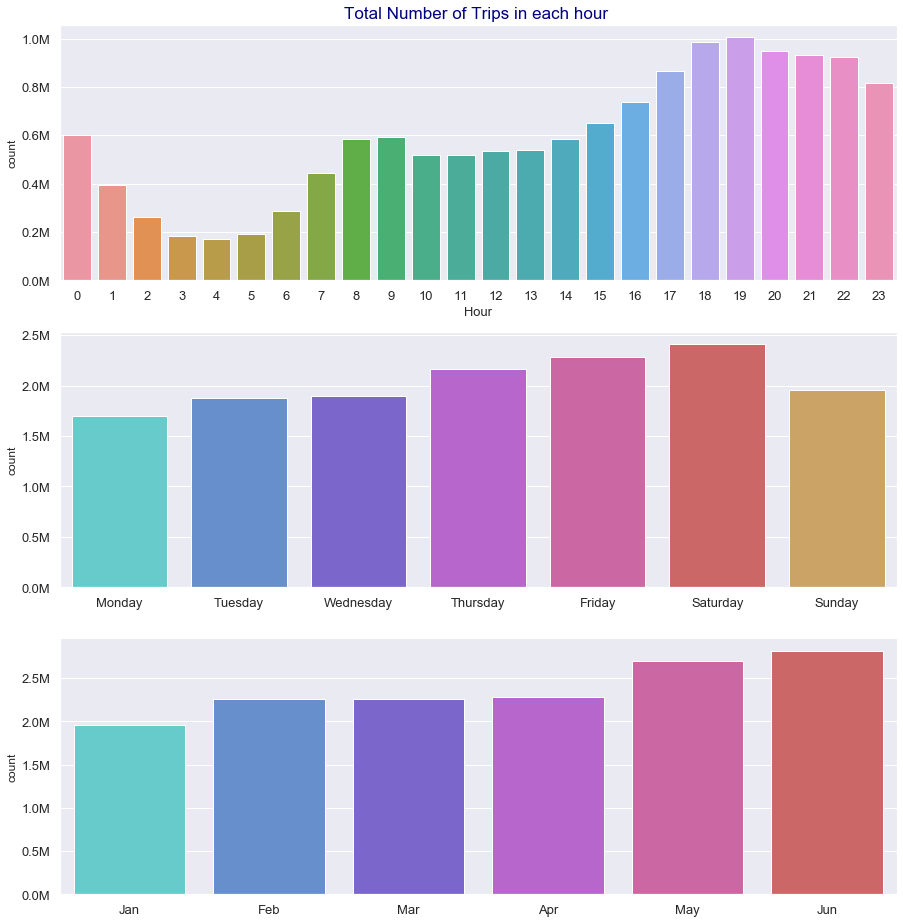

In [43]:
# Create plots comparing demand per different time categories:
fig = plt.figure(figsize = (15,16))
formatter = FuncFormatter(millions_format)

plt.subplot(3,1,1) #this plot could have a polar format, although I'm not sure it'd be a better viz.
ax1 = sns.countplot(df_uber.hour, order = range(24))
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.title('Total Number of Trips in each hour ', fontsize=17, color='navy')
plt.xlabel('Hour', fontsize=13)

plt.subplot(3,1,2)
ax2 = sns.countplot(df_uber.weekday, order = range(7))
ax2.set_xticklabels(weekday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.subplot(3,1,3) #same as the line plot but with less granularity, perhaps easier to visualize the MOM growth
ax3 = sns.countplot(df_uber.month)
ax3.set_xticklabels(month_labels)
ax3.yaxis.set_major_formatter(formatter)
#plt.text(0, 3100000, 'Consistent growth in the number of trips from month to month!', color='navy', size=15)
plt.tick_params(labelsize=13)
plt.xlabel('')

#fig.subplots_adjust(hspace=.5)
plt.show()
#2015-01-01 00:00:00 2015-06-30 23:00:00 180 days 23:00:00

In [44]:
def is_peak_hour(x):
    """ 
    Function that takes an array(x) with two integers representing 
    hour of the day and weekday, respectively, and
    returns 1 if it's peak hour as defined, 0 otherwise.
    """
    return 1 if x[0] in (7,8,9,16,17,18) and x[1] < 5 else 0 #total peak hour periods = 6h

In [45]:
df_uber['peak_hour'] = pd.Series(map(lambda x: is_peak_hour(x), df_uber.loc[:, ['hour', 'weekday']].values))

In [46]:
df_uber.head()

,Dispatching_base_num,Affiliated_base_num,locationID,pu_date_hour,pu_date,year,month,day,hour,weekday,peak_hour
0,B02617,B02617,141,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6,0
1,B02617,B02617,65,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6,0
2,B02617,B02617,100,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6,0
3,B02617,B02774,80,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6,0
4,B02617,B02617,90,2015-05-17 09:00:00,2015-05-17,2015,5,17,9,6,0


C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


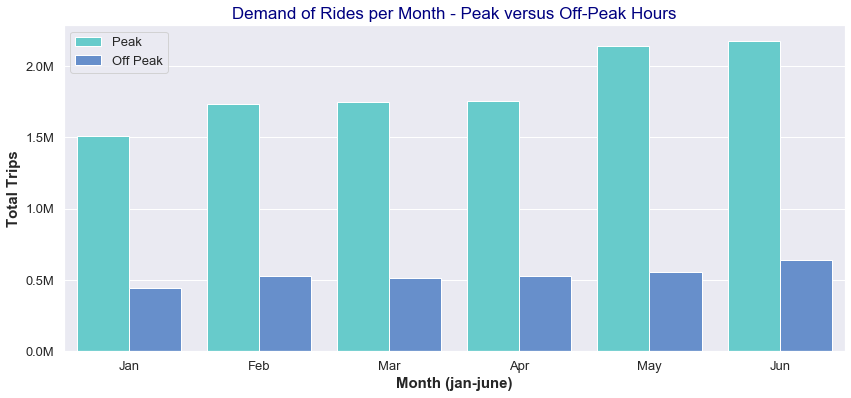

In [47]:
#Plot the total number of trips per month during peak hours and off-peak hours.
#Count for peak hours must represent more than 25% (6h) of the total rides to be more significant than non-peak hours.
plt.figure(figsize = (14, 6))
formatter = FuncFormatter(millions_format)

#to add labels and operate on data, use pivot instead of countplot directly with hue.
ax = sns.countplot(df_uber['month'], hue = df_uber['peak_hour'])
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

handles, labels = ax.get_legend_handles_labels() #will cause the warning msg that can be ignored 
plt.legend(handles, labels=['Peak', 'Off Peak'], loc='best', fontsize=13)
plt.tick_params(labelsize=13)
plt.xlabel('Month (jan-june)', fontsize = 15, weight='bold')
plt.ylabel('Total Trips', fontsize = 15, weight='bold')
plt.title('Demand of Rides per Month - Peak versus Off-Peak Hours', fontsize = 17, color='navy')
plt.show()


In [48]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [49]:
df1 = pd.read_csv('uber-raw-data-janjune-15.csv')
df1.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [51]:
df2 = pd.read_csv('taxi+_zone_lookup.csv')
df2.head()

,locationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [52]:
df3 = pd.merge(df1, df2, on = 'locationID')
df3.set_index('locationID', inplace = True)

In [53]:
df3.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,Borough,Zone,service_zone
locationID,,,,,,
141,B02617,2015-05-17 09:47:00,B02617,Manhattan,Lenox Hill West,Yellow Zone
141,B02617,2015-05-17 09:50:00,B02617,Manhattan,Lenox Hill West,Yellow Zone
141,B02617,2015-05-17 09:53:00,B02617,Manhattan,Lenox Hill West,Yellow Zone
141,B02617,2015-05-17 10:00:00,B02617,Manhattan,Lenox Hill West,Yellow Zone
141,B02617,2015-05-17 10:00:00,B02617,Manhattan,Lenox Hill West,Yellow Zone


(0, 10889613.0)

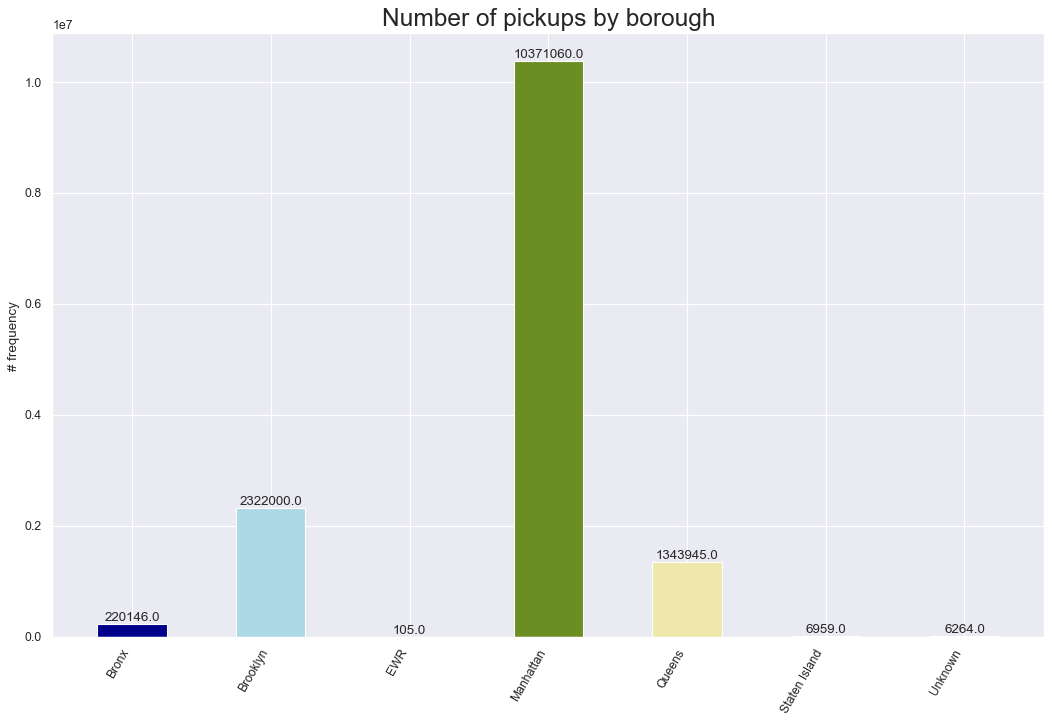

In [54]:
import random

# Import Data
#df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")

# Prepare Data
df = df3.groupby('Borough').size().reset_index(name='counts')
n = df['Borough'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['Borough'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Decoration
plt.gca().set_xticklabels(df['Borough'], rotation=60, horizontalalignment= 'right')
plt.title("Number of pickups by borough", fontsize=22)
plt.ylabel('# frequency ')
plt.ylim(0)

In [55]:
import random

# Import Data
#df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")

# Prepare Data
df = df3.groupby('Zone').size().reset_index(name='counts')
n = df['Zone'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(200,200), dpi= 80)
plt.bar(df['Zone'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Decoration
plt.gca().set_xticklabels(df['Zone'], rotation=60, horizontalalignment= 'right')
plt.title("Number of pickups by borough", fontsize=22)
plt.ylabel('# frequency ')
plt.ylim(0)

(0, 483768.6)

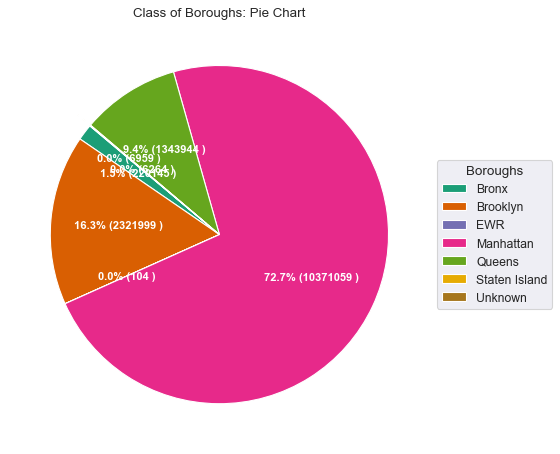

In [55]:
import numpy as np
#df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")

# Prepare Data
df = df3.groupby('Borough').size().reset_index(name='counts')

# Draw Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df['counts']
categories = df['Borough']
explode = [0,0,0,0,0,0.1,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),textprops=dict(color="w"), colors=plt.cm.Dark2.colors,startangle=140,explode=explode)

# Decoration
ax.legend(wedges, categories, title="Boroughs", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Class of Boroughs: Pie Chart")
plt.show()

In [1]:
#calender map and heat map with day time and hours for the boroughs 
! pip install jupyterthemes


  Using cached https://files.pythonhosted.org/packages/8a/08/9dee6dfd7f2aad6c30282d55c8f495b4dc1e4747b4e2bdbeb80572ddf312/jupyterthemes-0.20.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/d2/665cda6614e3556eaeb7553a3a2963624c2e3bc9636777a1bb654b87b027/lesscpy-0.14.0-py2.py3-none-any.whl
